**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Constant Thermal Conductivity, Constant Source, and Robin BC

**Student(s):**  Kyle Mills and Billy Manco and Donaita Anglade <br>
**Course:** Engy-4390: Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** Dr. Subash Sharma and Dr. Valmor de Almeida

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**13 Dec 2024**

---
## Table of Contents<a id = "toc"></a>
* [Problem](#Problem)
  + [Objectives](#Obj)
  + [Data](#Data)
  + [Domain](#Domain) 
* [Test Two](#test)
  + [Results](#Results)
  + [Comparing to Gold Solution](#Comparison)
  + [Comparing to Analytical Solution](#Analytical) 
* [Conclusion](#Conclusion) 
---

## [Problem](#toc)<a id = "Problem"></a>

Find temperature distribution, derive heat flux, employ the Rayleigh-Ritz method 

### [Objective](#toc)<a id = "Data">

+ Find the temperature distribution *u*(*x*).
+ Determine the heat flux *q*(*x*)=-*ku'*(*x*)
+ Compare the analytical and numerical solutions
+ Compare the numerical solutions to a gold standard solution
+ Interpretation of *u*(*x*) and *q*(*x*)

### [Problem Data](#toc)<a id = 'Data'></a>

> a = 0 cm <br>
> b = 5 cm <br>
> u_ref(a) = 20 C <br>
> u_ref(b) = 40 C <br>
> k = 42 W/(mK) <br>
> f = 206151 W/m^2 

### [Domain](#toc)<a id = "Domain"></a>

In [10]:
'''Domain'''
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min = 0    # m
x_max = 0.05 # m

degree = 2  # Degree of the lagrange polinomials used
n_elem = 10 # Number of elements used

In [11]:
'''Domain partition'''
from pyfires import get_domain_partition
'''Parent mapping'''
from pyfires import get_parent_mapping
'''The basis functions'''
from pyfires import get_parent_basis_functions
'''Again the function for the obtaining of the basis functions'''
from pyfires import global_basis_function
'''All global basis functions'''
from pyfires import get_global_basis_functions
'''Inner product'''
from pyfires import inner_product

In [12]:
'''FEM Solution'''
'''Domain partition'''
domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]

## **Important Note**
With a Robin BC at both ends of the domain, the basis functions evaluated at the corresponding points must not be zero. They must evaluate exactly to 1.0 and this is not the case as demonstrated below. Therefore the current FEM implemented in `pyfires.py` is not able to handle Robin BC.

In [14]:
phi_list[0](x_min)

array([-0.])

In [15]:
phi_list[-2](x_max)

array([0.])

## [Implementing Data](#toc)<a id = "test"></a>

Test two constraints the system with a constant thermal conductivity and a constant heat source using a Robin boundary condition. The goal of simulating the domain with these conditions is to produce a graphical solution on how heat is transfered throughout the domain. 

In [18]:
'''Heat Transfer Coefficient'''
htc = 25 # W/m^2/K    #Heat transfer coefficient
u_ref_a = 20 # temperature at poin a in degrees C
u_ref_b = 40 # temperature at point b in degrees C

In [19]:
'''Thermal conductivity'''
from pyfires import linear_func
from pyfires import plot_func

k_func = linear_func(x_min, x_max, (42.0, 42.0)) # W/mK

'''Heating Power Density'''
f_func = linear_func(x_min, x_max, (824604, 824604)) # W/m^3

view_plots = False

In [20]:
if view_plots:
    n_plot_pts = 200
    title = 'Thermal Conductivity'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'K [W/mk]'
    plot_func(k_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Heating Power Density'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'f [W/m^3]'
    plot_func(f_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [21]:
'''Build FEM A Matrix'''
from pyfires import build_a_mtrx_robin_bc
a_mtrx = build_a_mtrx_robin_bc(phi_list, phi_prime_list, k_func, domain_partition, x_min, x_max, n_elem, htc)

In [22]:
'''Build load vector'''
from pyfires import build_b_vec_robin_bc

b_vec = build_b_vec_robin_bc(phi_list, phi_prime_list, f_func, domain_partition, x_min, x_max, n_elem, htc, u_ref_a, u_ref_b)

### [Results](#toc)<a id = "Results"></a>

In [24]:
'''Solution'''
'''Compute optimal coefficient vector'''
import numpy as np

c_star_vec = np.linalg.solve(a_mtrx, b_vec)

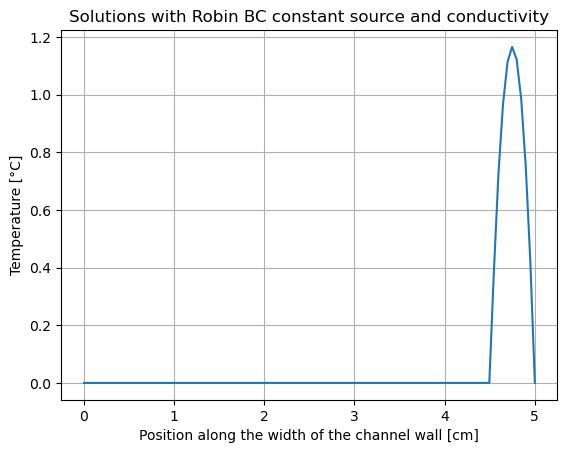

In [25]:
from pyfires import u_star_no_lift
u_star = lambda x: u_star_no_lift(x, phi_list, c_star_vec)
plot_func(u_star, x_min, x_max, 100,
          x_scale=100,
          title='Solutions with Robin BC constant source and conductivity', 
          xlabel='Position along the width of the channel wall [cm]',
          ylabel='Temperature [°C]')

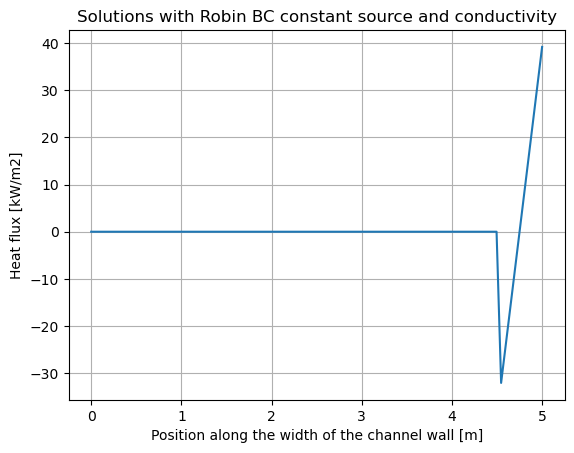

In [26]:
from pyfires import u_star_prime_no_lift
h_e = (x_max-x_min)/n_elem
q_x = lambda x: - k_func(x) * u_star_prime_no_lift(x, phi_prime_list, c_star_vec, h_e)
plot_func(q_x, x_min, x_max, 100, 
          x_scale=100, y_scale=1/1000,
          title='Solutions with Robin BC constant source and conductivity', 
          xlabel='Position along the width of the channel wall [m]',
          ylabel='Heat flux [kW/m2]')

In [27]:
'''Normal heat flux at boundaries'''
n_x_a = -1.0
n_x_b =  1.0
print('q_n(a) = ', (q_x(x_min) * n_x_a)/1000)  
print('q_n(b) = ', (q_x(x_max) * n_x_b)/1000)

q_n(a) =  [0.]
q_n(b) =  [39.16869]


### [Results Comparison with Gold-Data](#toc)<a id = "Comparison"></a>

In [29]:
import numpy as np
(x,u,q) = np.loadtxt('gold-data/02-test-gold.txt')
u_gold = np.column_stack((x,u))

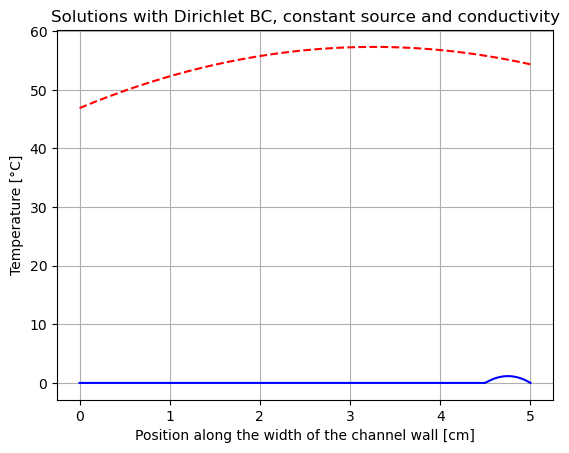

In [30]:
plot_func(u_star, x_min, x_max, 100,
          x_scale=100,
          title='Solutions with Dirichlet BC, constant source and conductivity', 
          xlabel='Position along the width of the channel wall [cm]',
          ylabel='Temperature [°C]', gold_data=u_gold)

In [31]:
import numpy as np
(x,u,q) = np.loadtxt('gold-data/02-test-gold.txt')
q_gold = np.column_stack((x,q))

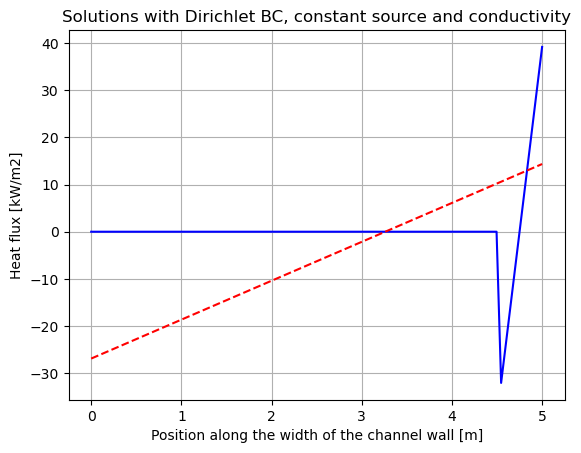

In [32]:
h_e = (x_max-x_min)/n_elem
q_x = lambda x: - k_func(x) * u_star_prime_no_lift(x, phi_prime_list, c_star_vec, h_e)
plot_func(q_x, x_min, x_max, 100, 
          x_scale=100, y_scale=1/1000,
          title='Solutions with Dirichlet BC, constant source and conductivity', 
          xlabel='Position along the width of the channel wall [m]',
          ylabel='Heat flux [kW/m2]', gold_data = q_gold)

### [Results Comparison with a Analytical Solution](#toc)<a id = "Analytical"></a>

## [Conclusion](#toc)<a id = "Conclusion"></a>